In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
import requests
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import optuna
import xgboost as xgb

/Users/alexabraham/anaconda3/envs/forecast_stickers_kaggle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load

In [2]:
sales_daily = pd.read_csv("./data/external/train.csv").assign(
    date = lambda df_: pd.to_datetime(df_['date']),
    series_id = lambda df_: df_['country'].str.cat([df_['store'], df_['product']], sep='|')
    )

In [3]:
sales_daily.head()

,id,date,country,store,product,num_sold,series_id
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,Canada|Discount Stickers|Holographic Goose
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,Canada|Discount Stickers|Kaggle
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,Canada|Discount Stickers|Kaggle Tiers
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,Canada|Discount Stickers|Kerneler
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,Canada|Discount Stickers|Kerneler Dark Mode


In [4]:
def extract_gdp_per_capita(country_code, year):
    """
    Adapted from https://www.kaggle.com/competitions/playground-series-s5e1/discussion/554349.
    """

    url='https://api.worldbank.org/v2/country/{0}/indicator/NY.GDP.PCAP.CD?date={1}&format=json'
    response = requests.get(url.format(country_code, year)).json()

    return response[1][0]['value']

# per CountryCode-year: request GDP per capita.
# concatenate dataframe of CountryCode | Country | Year | GDP, for integration to Kaggle source

countries_code_map = {
    'Canada': 'CAN', 
    'Finland': 'FIN',
    'Italy': 'ITA',
    'Kenya': 'KEN',
    'Norway': 'NOR',
    'Singapore': 'SGP'
    }

countries_gdp_yearly = []
for country_title, country_code in countries_code_map.items():
    
    values_yearly = [
        {'year': i, 'gdp_per_capita': extract_gdp_per_capita(country_code, i)}
        for i in range(2010, 2019+1)
        ]
    values_yearly = [pd.DataFrame(x, index=[0]) for x in values_yearly]
    values_yearly = pd.concat(values_yearly, axis=0)
    
    values_yearly = values_yearly.assign(
        country = country_title,
        country_code = country_code
        )
    
    countries_gdp_yearly.append(values_yearly)

    print(f"{country_title} ({country_code}) GDP Per Capita extraction complete.")

countries_gdp_yearly = pd.concat(countries_gdp_yearly, axis=0)

countries_gdp_yearly = countries_gdp_yearly.assign(
    gdp_per_capita_log = lambda df_: np.log(df_['gdp_per_capita'])
    )

Canada (CAN) GDP Per Capita extraction complete.
Finland (FIN) GDP Per Capita extraction complete.
Italy (ITA) GDP Per Capita extraction complete.
Kenya (KEN) GDP Per Capita extraction complete.
Norway (NOR) GDP Per Capita extraction complete.
Singapore (SGP) GDP Per Capita extraction complete.


''

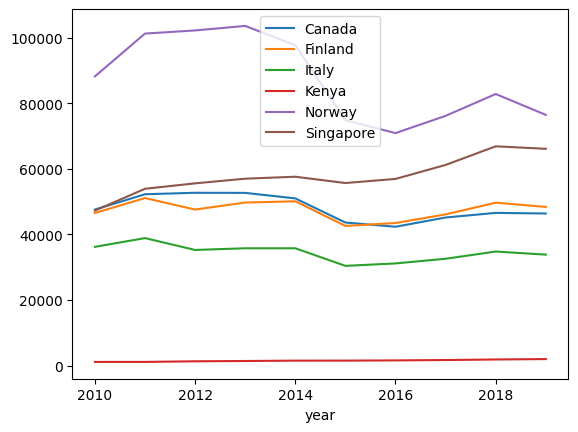

In [5]:
(
    countries_gdp_yearly
    .set_index('year')
    .groupby('country')
    ['gdp_per_capita']
    .plot(legend=True)
)
;

# Data Understanding

## Data Description Report: "Surface Properties"

In [6]:
sales_daily['id'].is_unique

True

### Volumetric Analyses

In [7]:
sales_daily.shape

(230130, 7)

In [8]:
sales_daily['series_id'].nunique()

90

In [9]:
sales_daily['date'].nunique()

2557

In [10]:
sales_daily['series_id'].value_counts().value_counts()

count
2557    90
Name: count, dtype: int64

In [11]:
sales_daily['product'].value_counts(dropna=False)

product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64

In [12]:
sales_daily['country'].value_counts(dropna=False)

country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64

In [13]:
sales_daily['store'].value_counts(dropna=False)

store
Discount Stickers       76710
Stickers for Less       76710
Premium Sticker Mart    76710
Name: count, dtype: int64

### Fields' Types and Values

In [14]:
sales_daily['date'].describe()

count                 230130
mean     2013-07-02 00:00:00
min      2010-01-01 00:00:00
25%      2011-10-02 00:00:00
50%      2013-07-02 00:00:00
75%      2015-04-02 00:00:00
max      2016-12-31 00:00:00
Name: date, dtype: object

In [15]:
sales_daily['num_sold'].describe()

count    221259.000000
mean        752.527382
std         690.165445
min           5.000000
25%         219.000000
50%         605.000000
75%        1114.000000
max        5939.000000
Name: num_sold, dtype: float64

## Data Quality Report

In [16]:
sales_daily.isnull().mean()

id           0.000000
date         0.000000
country      0.000000
store        0.000000
product      0.000000
num_sold     0.038548
series_id    0.000000
dtype: float64

In [17]:
# are null sales events concentrated on a particular date?
# doesn't appear so
sales_daily.query("num_sold.isnull()")['date'].value_counts()

date
2010-04-21    7
2010-04-01    7
2010-05-11    7
2010-06-01    7
2010-07-24    6
             ..
2014-03-08    2
2014-03-09    2
2014-03-10    2
2014-03-11    2
2016-12-31    2
Name: count, Length: 2557, dtype: int64

In [18]:
sales_daily.query("num_sold.isnull()")['series_id'].value_counts()

series_id
Canada|Discount Stickers|Holographic Goose       2557
Kenya|Discount Stickers|Holographic Goose        2557
Kenya|Stickers for Less|Holographic Goose        1358
Canada|Stickers for Less|Holographic Goose       1308
Kenya|Premium Sticker Mart|Holographic Goose      646
Canada|Premium Sticker Mart|Holographic Goose     380
Kenya|Discount Stickers|Kerneler                   63
Kenya|Discount Stickers|Kerneler Dark Mode          1
Canada|Discount Stickers|Kerneler                   1
Name: count, dtype: int64

## Data Exploration Report

In [19]:
# a naive model: series' historical average sales, daily

is_training = (
    (sales_daily['date'] >= pd.to_datetime('2010-01-01'))
    & (sales_daily['date'] < pd.to_datetime("2014-01-01"))
)

is_validation = sales_daily['date'] >= pd.to_datetime("2014-01-01")

# is_training.sum(), is_validation.sum()

# with original train data: using strictly train segment, groupby average
predictions_naive = (
    sales_daily
    .loc[is_training]
    .groupby('series_id')
    [['num_sold']]
    .agg('mean')
    .reset_index(drop=False)
)

predictions_naive_evaluate = pd.merge(
    sales_daily.loc[is_validation],
    predictions_naive.rename(columns={'num_sold': 'yhat'}),
    how='left'
    )

# expect a couple series with all null
predictions_naive.isnull().sum()
# recommended in this discussion: https://www.kaggle.com/competitions/playground-series-s5e1/discussion/554553 
predictions_naive_evaluate = predictions_naive_evaluate.dropna()

mean_absolute_percentage_error(
    predictions_naive_evaluate['num_sold'],
    predictions_naive_evaluate['yhat']
)

0.17863411864432988

In [20]:
predictions_naive_evaluate.shape

(95233, 8)

In [21]:
# a naive model: series' historical average sales, daily

is_training = (
    (sales_daily['date'] >= pd.to_datetime('2013-01-01'))
    & (sales_daily['date'] < pd.to_datetime("2014-01-01"))
)

is_validation = sales_daily['date'] >= pd.to_datetime("2014-01-01")

# is_training.sum(), is_validation.sum()

# with original train data: using strictly train segment, groupby average
predictions_naive = (
    sales_daily
    .loc[is_training]
    .groupby('series_id')
    [['num_sold']]
    .agg('mean')
    .reset_index(drop=False)
)

predictions_naive_evaluate = pd.merge(
    sales_daily.loc[is_validation],
    predictions_naive.rename(columns={'num_sold': 'yhat'}),
    how='left'
    )

# expect a couple series with all null
predictions_naive.isnull().sum()
# recommended in this discussion: https://www.kaggle.com/competitions/playground-series-s5e1/discussion/554553 
predictions_naive_evaluate = predictions_naive_evaluate.dropna()

mean_absolute_percentage_error(
    predictions_naive_evaluate['num_sold'],
    predictions_naive_evaluate['yhat']
)

0.17764235834140726

''

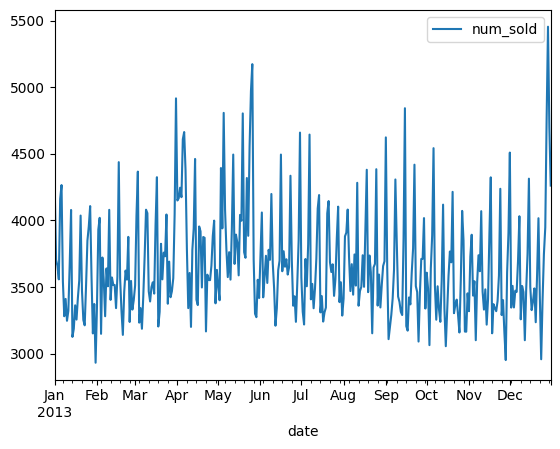

In [22]:
sales_sample_daily = sales_daily.query("series_id == 'Norway|Premium Sticker Mart|Kaggle'")

(
    sales_sample_daily
    .loc[is_training]
    [['date', 'num_sold']]
    .set_index('date')
    .plot
    .line()
)
;

# Data Preparation

In [23]:
def transform_calendar_features(df):

    df = (
        df
        .assign(
            year = lambda df_: df_['date'].dt.year,
            month = lambda df_: df_['date'].dt.month,
            week_of_year = lambda df_: df_['date'].dt.isocalendar().week,
            day_of_week = lambda df_: df_['date'].dt.day_name(),
            # President's Day is the 'third Monday in February'
            day_of_month = lambda df_: df_['date'].dt.day,
            day_of_year = lambda df_: df_['date'].dt.dayofyear,
            # week of month would be ambiguous because, one week may span 2 months,
            days_since_start = lambda df_: (df['date'] - pd.to_datetime("2010-01-01")).dt.days
            )
        .assign(
            # as day_of_year rises, don't expect monotonic relationship with outcome.
            # rather, expect periodic (sinusoidal) relationship.
            # as sin(x) rises, so too does outcome ...
            # ensure one cycle over one year.
            # at baseline, one sinusoidal cycle occurs per 2π
            day_of_year_sin = lambda df_: np.sin(df_['day_of_year'] * 2 * np.pi / 365),
            day_of_year_cos = lambda df_: np.cos(df_['day_of_year'] * 2 * np.pi / 365),

            day_of_month_sin = lambda df_: np.sin(df_['day_of_month'] * 2 * np.pi / 30),
            day_of_month_cos = lambda df_: np.cos(df_['day_of_month'] * 2 * np.pi / 30),

            # exploratory visuals suggest ~2-year cycles
            days_since_start_macro_sin = lambda df_: np.sin(df_['days_since_start'] * 2 * np.pi / 730),
            days_since_start_macro_cos = lambda df_: np.cos(df_['days_since_start'] * 2 * np.pi / 730),

            )

        )
    
    return df

def integrate_external_features(df):

    df = pd.merge(df, countries_gdp_yearly, how='left')
    assert df['gdp_per_capita'].notnull().all().all()

    return df

sales_daily = transform_calendar_features(sales_daily)
sales_daily = integrate_external_features(sales_daily)

In [24]:
sales_daily.columns

Index(['id', 'date', 'country', 'store', 'product', 'num_sold', 'series_id',
       'year', 'month', 'week_of_year', 'day_of_week', 'day_of_month',
       'day_of_year', 'days_since_start', 'day_of_year_sin', 'day_of_year_cos',
       'day_of_month_sin', 'day_of_month_cos', 'days_since_start_macro_sin',
       'days_since_start_macro_cos', 'gdp_per_capita', 'country_code',
       'gdp_per_capita_log'],
      dtype='object')

In [25]:
FEATURES_TO_ONEHOT = [
    'country', 
    'store',
    'product',
    # year attempted, but then omitted, because year-grained shifts
    # should be explained by exogenous factors, 
    # out-of-sample forecasts that aren't flat
    'month', 
    'week_of_year', 
    'day_of_week'
    ]
FEATURES_NUMERIC_LEVEL = [
    'gdp_per_capita_log',
    'day_of_month', 
    'day_of_month_sin',
    'day_of_month_cos',
    'day_of_year_sin',
    'day_of_year_cos',
    'day_of_year',
    'days_since_start_macro_sin',
    'days_since_start_macro_cos',
    'days_since_start'
    ]
FEATURES_SOURCE_FORM = FEATURES_TO_ONEHOT + FEATURES_NUMERIC_LEVEL
ATTRIBUTES = ['series_id', 'date', 'id']

sales_daily_complete = sales_daily.dropna(subset='num_sold')

XY = sales_daily_complete[['num_sold'] + ATTRIBUTES + FEATURES_SOURCE_FORM]

XY = XY.assign(num_sold_log = lambda df_: np.log(df_['num_sold']))

feature_transform_pipeline = ColumnTransformer([
    ('transformer_onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), FEATURES_TO_ONEHOT),
    ('transformer_std', StandardScaler(), FEATURES_NUMERIC_LEVEL)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
    )
feature_transform_pipeline.set_output(transform='pandas')

XY = feature_transform_pipeline.fit_transform(XY)

FEATURES_UNIVERSE = list( set(XY.columns).difference(set(ATTRIBUTES + ['num_sold', 'num_sold_log'])) )
FEATURES_GLOBAL_MODEL = [
    x for x in FEATURES_UNIVERSE
    # inclusion yields flat predictions
    if not any(stem in x for stem in ['days_since_start'])
    ]
FEATURES_LOCAL_MODEL = [
    x for x in FEATURES_UNIVERSE 
    if not any(stem in x for stem in ['country', 'store', 'product'])
    ]

# Modeling

## Global Model

In [26]:
kfolds = [

    # validation set 2014-16 matches ultimate test set's length, 2017-19
    ( 
        ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2014-01-01")) ),
        XY['date'] >= pd.to_datetime("2014-01-01")
    ),

    ( 
        ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2016-01-01")) ),
        XY['date'] >= pd.to_datetime("2016-01-01")
    )

    ]

kfolds_evaluation = []
for is_training, is_validation in kfolds:

    model_global = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    model_global.fit(
        XY.loc[is_training, FEATURES_GLOBAL_MODEL],
        XY.loc[is_training, 'num_sold_log']
        )
    
    predictions = (
        XY
        .copy()
        .assign(yhat = lambda df_: np.exp(model_global.predict(df_[FEATURES_GLOBAL_MODEL])))
        )
    
    scores = {
        'validation': mean_absolute_percentage_error( 
            predictions.loc[is_validation, 'num_sold'],
            predictions.loc[is_validation, 'yhat']
            ),
        'train': mean_absolute_percentage_error( 
            predictions.loc[is_training, 'num_sold'],
            predictions.loc[is_training, 'yhat']
            )
        }
    
    kfolds_evaluation.append(scores)

kfolds_evaluation

[{'validation': 0.08861105160381477, 'train': 0.01844193705725554},
 {'validation': 0.0715132956372125, 'train': 0.01822308683540498}]

<Axes: xlabel='date'>

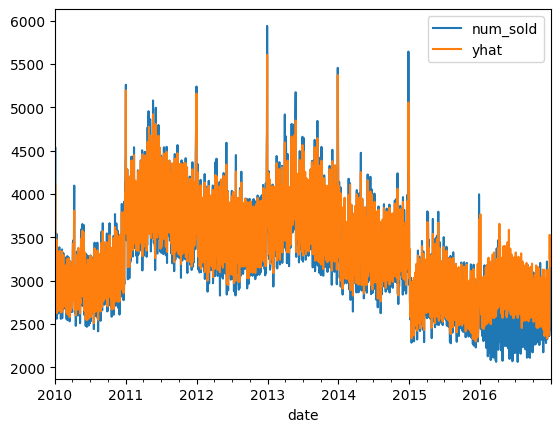

In [27]:
predictions_sample = predictions.query("series_id == 'Norway|Premium Sticker Mart|Kaggle'")

predictions_sample.set_index('date')[['num_sold', 'yhat']].plot.line()

In [28]:
# WIP: could gradient boosting machine improve global model?

# def objective(trial):

#     ROUNDS_COUNT = 1_000

#     param = {
#         "objective": "reg:squarederror",
#         "booster": trial.suggest_categorical(
#             "booster", ["gbtree", "gblinear", "dart"]
#         ),
#         "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
#         "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
#         "subsample": trial.suggest_float("subsample", 0.4, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
#     }

#     if param["booster"] in ["gbtree", "dart"]:
#         param["max_depth"] = trial.suggest_int("max_depth", 1, 9, step=2)

#         param["min_child_weight"] = trial.suggest_int("min_child_weight", 1, 10)
#         param["eta"] = trial.suggest_float("eta", 1e-5, 0.01, log=True)

#         param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
#         param["grow_policy"] = trial.suggest_categorical(
#             "grow_policy", ["depthwise", "lossguide"]
#         )

#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical(
#             "sample_type", ["uniform", "weighted"]
#         )
#         param["normalize_type"] = trial.suggest_categorical(
#             "normalize_type", ["tree", "forest"]
#         )
#         param["rate_drop"] = trial.suggest_float(
#             "rate_drop", 1e-8, 1.0, log=True
#         )
#         param["skip_drop"] = trial.suggest_float(
#             "skip_drop", 1e-8, 1.0, log=True
#         )


#     kfolds_evaluation = []
#     for is_training, is_validation in kfolds:

#         dtrain = xgb.DMatrix(
#             XY.loc[is_training, FEATURES_GLOBAL_MODEL], 
#             label=XY.loc[is_training, 'num_sold_log']
#             )
#         dtest = xgb.DMatrix(XY[FEATURES_GLOBAL_MODEL])

#         model_global = xgb.train(param, dtrain, ROUNDS_COUNT)
        
#         yhat = model_global.predict(dtest)
#         predictions = (
#             XY
#             .copy()
#             .assign(yhat = lambda df_: np.exp(yhat))
#             )

#         scores = {
#             'validation': mean_absolute_percentage_error( 
#                 predictions.loc[is_validation, 'num_sold'],
#                 predictions.loc[is_validation, 'yhat']
#                 ),
#             'train': mean_absolute_percentage_error( 
#                 predictions.loc[is_training, 'num_sold'],
#                 predictions.loc[is_training, 'yhat']
#                 )
#             }
        
#         kfolds_evaluation.append(scores)

#     score_overall = np.mean([ 
#         kfolds_evaluation[0]['validation'], 
#         kfolds_evaluation[1]['validation'] 
#         ])
    
#     return score_overall

# study = optuna.create_study()

# study.optimize(
#     objective,
#     n_trials=50,
#     catch=(ValueError,),
#     n_jobs=-1,
#     timeout=12 * 60 * 60,
# )

In [29]:
# model_global = RandomForestRegressor(n_estimators=100, n_jobs=-1)
# model_global.fit(XY[FEATURES_GLOBAL_MODEL], XY['num_sold_log'])

## Local Models

In [30]:
# from previous retail forecasting competitions' leaders,
# plus theoretically expected heterogeneity between series: 
# one model per segment

segments_XY = {grp: df for grp, df in XY.groupby('series_id')}

# even when split into many dataframes, *index-based* subsets.
# indexes maintained when dataframe splits.
kfolds = [

    # validation set 2014-16 matches ultimate test set's length, 2017-19
    ( 
        ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2014-01-01")) ),
        XY['date'] >= pd.to_datetime("2014-01-01")
    ),

    ( 
        ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2016-01-01")) ),
        XY['date'] >= pd.to_datetime("2016-01-01")
    )

    ]

kfolds_evaluation = []
for is_training, is_validation in kfolds:

    # per group: fit model on train, predict on validation
    # WARNING: one model instance, then fitting it on each segment,
    # does not imply separate model objects. they're all tied together.
        # model = LinearRegression()
    segments_models = {
        grp: Ridge(1e-1).fit(
            XY.loc[is_training, FEATURES_LOCAL_MODEL], 
            XY.loc[is_training, 'num_sold_log']
            )
        for grp, XY in segments_XY.items()
        }

    segments_predictions = [
        df.assign(
            yhat = lambda df_: np.exp(segments_models[grp].predict(df_[FEATURES_LOCAL_MODEL])) 
            )
        for grp, df in segments_XY.items()
        ]

    predictions = pd.concat(segments_predictions, axis=0)

    scores = {
        'validation': mean_absolute_percentage_error( 
            predictions.loc[is_validation, 'num_sold'],
            predictions.loc[is_validation, 'yhat']
            ),
        'train': mean_absolute_percentage_error( 
            predictions.loc[is_training, 'num_sold'],
            predictions.loc[is_training, 'yhat']
            )
        }
    
    kfolds_evaluation.append(scores)

In [31]:
kfolds_evaluation

[{'validation': 0.0744946463660479, 'train': 0.04556600626556164},
 {'validation': 0.05088036673633741, 'train': 0.04635338959764835}]

In [32]:
def objective(trial):

    parameters = {'alpha': trial.suggest_float("alpha", 1e-4, 1, log=True)}

    kfolds_evaluation = []
    for is_training, is_validation in kfolds:

        # per group: fit model on train, predict on validation
        segments_models = {
            grp: Ridge(**parameters).fit(
                XY.loc[is_training, FEATURES_LOCAL_MODEL], 
                XY.loc[is_training, 'num_sold_log']
                )
            for grp, XY in segments_XY.items()
            }

        segments_predictions = [
            df.assign(
                yhat = lambda df_: np.exp(segments_models[grp].predict(df_[FEATURES_LOCAL_MODEL])) 
                )
            for grp, df in segments_XY.items()
            ]

        predictions = pd.concat(segments_predictions, axis=0)

        scores = {
            'validation': mean_absolute_percentage_error( 
                predictions.loc[is_validation, 'num_sold'],
                predictions.loc[is_validation, 'yhat']
                ),
            'train': mean_absolute_percentage_error( 
                predictions.loc[is_training, 'num_sold'],
                predictions.loc[is_training, 'yhat']
                )
            }
        
        kfolds_evaluation.append(scores)

    score_overall = np.mean([ 
        kfolds_evaluation[0]['validation'], 
        kfolds_evaluation[1]['validation'] 
        ])
    
    return score_overall

study = optuna.create_study()

study.optimize(
    objective,
    n_trials=50,
    catch=(ValueError,),
    n_jobs=-1,
    timeout=12 * 60 * 60,
)

[I 2025-01-05 22:16:16,844] A new study created in memory with name: no-name-e8d9cf69-99ef-4540-bd0b-24406426c755
[I 2025-01-05 22:16:21,846] Trial 1 finished with value: 0.08247989358099486 and parameters: {'alpha': 0.00011548315126878178}. Best is trial 1 with value: 0.08247989358099486.
[I 2025-01-05 22:16:21,869] Trial 6 finished with value: 0.05611433509576448 and parameters: {'alpha': 0.6202070549968495}. Best is trial 6 with value: 0.05611433509576448.
[I 2025-01-05 22:16:22,204] Trial 5 finished with value: 0.0530043184467395 and parameters: {'alpha': 0.29983761246422036}. Best is trial 5 with value: 0.0530043184467395.
[I 2025-01-05 22:16:22,221] Trial 4 finished with value: 0.07345081865553994 and parameters: {'alpha': 0.007665335986208017}. Best is trial 5 with value: 0.0530043184467395.
[I 2025-01-05 22:16:22,259] Trial 13 finished with value: 0.07731347113188614 and parameters: {'alpha': 0.00047187383531760744}. Best is trial 5 with value: 0.0530043184467395.
[I 2025-01-05

In [33]:
study.best_trial, study.best_params, study.best_value

(FrozenTrial(number=40, state=TrialState.COMPLETE, values=[0.05266432756598278], datetime_start=datetime.datetime(2025, 1, 5, 22, 16, 28, 569400), datetime_complete=datetime.datetime(2025, 1, 5, 22, 16, 34, 970073), params={'alpha': 0.3260167387655398}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'alpha': FloatDistribution(high=1.0, log=True, low=0.0001, step=None)}, trial_id=40, value=None),
 {'alpha': 0.3260167387655398},
 0.05266432756598278)

In [34]:
# INCOMPLETE: stalled after ~20 minute runtime, and score not better than 0.1

# def objective(trial):

#     ROUNDS_COUNT = 100

#     param = {
#         "objective": "reg:squarederror",
#         "booster": trial.suggest_categorical(
#             "booster", ["gbtree", "gblinear", "dart"]
#         ),
#         "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
#         "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
#         "subsample": trial.suggest_float("subsample", 0.4, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
#     }

#     if param["booster"] in ["gbtree", "dart"]:
#         param["max_depth"] = trial.suggest_int("max_depth", 1, 9, step=2)

#         param["min_child_weight"] = trial.suggest_int("min_child_weight", 1, 10)
#         param["eta"] = trial.suggest_float("eta", 1e-5, 0.01, log=True)

#         param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
#         param["grow_policy"] = trial.suggest_categorical(
#             "grow_policy", ["depthwise", "lossguide"]
#         )

#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical(
#             "sample_type", ["uniform", "weighted"]
#         )
#         param["normalize_type"] = trial.suggest_categorical(
#             "normalize_type", ["tree", "forest"]
#         )
#         param["rate_drop"] = trial.suggest_float(
#             "rate_drop", 1e-8, 1.0, log=True
#         )
#         param["skip_drop"] = trial.suggest_float(
#             "skip_drop", 1e-8, 1.0, log=True
#         )

#     kfolds_evaluation = []
#     for is_training, is_validation in kfolds:

#         segments_models = {}
#         segments_predictions = []
#         for grp, XY in segments_XY.items():

#             dtrain = xgb.DMatrix(
#                 XY.loc[is_training, FEATURES_LOCAL_MODEL], 
#                 label=XY.loc[is_training, 'num_sold_log']
#                 )
#             dtest = xgb.DMatrix(XY[FEATURES_LOCAL_MODEL])

#             model_global = xgb.train(param, dtrain, ROUNDS_COUNT)
#             segments_models[grp] = model_global
        
#             yhat = model_global.predict(dtest)
#             predictions = (
#                 XY
#                 .copy()
#                 .assign(yhat = lambda df_: np.exp(yhat))
#                 )
#             segments_predictions.append(predictions)

#         predictions = pd.concat(segments_predictions, axis=0)

#         scores = {
#             'validation': mean_absolute_percentage_error( 
#                 predictions.loc[is_validation, 'num_sold'],
#                 predictions.loc[is_validation, 'yhat']
#                 ),
#             'train': mean_absolute_percentage_error( 
#                 predictions.loc[is_training, 'num_sold'],
#                 predictions.loc[is_training, 'yhat']
#                 )
#             }
        
#         kfolds_evaluation.append(scores)

#     score_overall = np.mean([ 
#         kfolds_evaluation[0]['validation'], 
#         kfolds_evaluation[1]['validation'] 
#         ])
    
#     return score_overall

# study = optuna.create_study()

# study.optimize(
#     objective,
#     n_trials=25,
#     catch=(ValueError,),
#     n_jobs=-1,
#     timeout=60 * 10,
# )

# study.best_trial, study.best_params, study.best_value

In [35]:
RIDGE_ALPHA_TUNED = study.best_params['alpha']

# from previous retail forecasting competitions' leaders,
# plus theoretically expected heterogeneity between series: 
# one model per segment

segments_XY = {grp: df for grp, df in XY.groupby('series_id')}

# even when split into many dataframes, *index-based* subsets.
# indexes maintained when dataframe splits.
kfolds = [

    # validation set 2014-16 matches ultimate test set's length, 2017-19
    ( 
        ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2014-01-01")) ),
        XY['date'] >= pd.to_datetime("2014-01-01")
    ),

    ( 
        ( (XY['date'] >= pd.to_datetime('2010-01-01')) & (XY['date'] < pd.to_datetime("2016-01-01")) ),
        XY['date'] >= pd.to_datetime("2016-01-01")
    )

    ]

kfolds_evaluation = []
for is_training, is_validation in kfolds:

    # per group: fit model on train, predict on validation
    # WARNING: one model instance, then fitting it on each segment,
    # does not imply separate model objects. they're all tied together.
        # model = LinearRegression()
    segments_models = {
        grp: Ridge(RIDGE_ALPHA_TUNED).fit(
            XY.loc[is_training, FEATURES_LOCAL_MODEL], 
            XY.loc[is_training, 'num_sold_log']
            )
        for grp, XY in segments_XY.items()
        }

    segments_predictions = [
        df.assign(
            yhat = lambda df_: np.exp(segments_models[grp].predict(df_[FEATURES_LOCAL_MODEL])) 
            )
        for grp, df in segments_XY.items()
        ]

    predictions = pd.concat(segments_predictions, axis=0)

    scores = {
        'validation': mean_absolute_percentage_error( 
            predictions.loc[is_validation, 'num_sold'],
            predictions.loc[is_validation, 'yhat']
            ),
        'train': mean_absolute_percentage_error( 
            predictions.loc[is_training, 'num_sold'],
            predictions.loc[is_training, 'yhat']
            )
        }
    
    kfolds_evaluation.append(scores)

kfolds_evaluation

[{'validation': 0.05499817556770692, 'train': 0.046563998743642136},
 {'validation': 0.05033047956425864, 'train': 0.04645540645647234}]

<Axes: xlabel='date'>

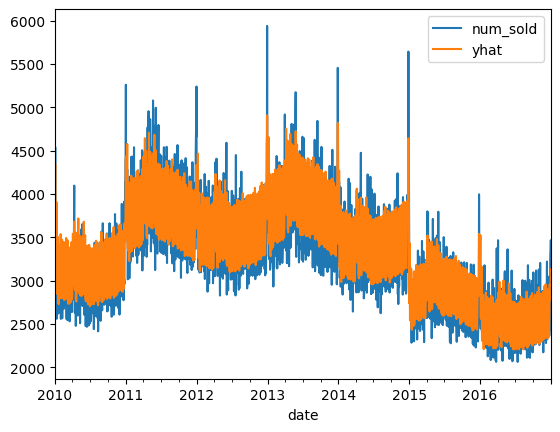

In [36]:
predictions_sample = predictions.query("series_id == 'Norway|Premium Sticker Mart|Kaggle'")

predictions_sample.set_index('date')[['num_sold', 'yhat']].plot.line()

In [37]:
(
    predictions
    .assign(mape = lambda df_: np.abs(100 * (df_['num_sold']/df_['yhat'] - 1)) )
    .sort_values('mape', ascending=False)
    .head(10)
)

,country_Canada,country_Finland,country_Italy,country_Kenya,country_Norway,country_Singapore,store_Discount Stickers,store_Premium Sticker Mart,store_Stickers for Less,product_Holographic Goose,...,days_since_start_macro_sin,days_since_start_macro_cos,days_since_start,num_sold,series_id,date,id,num_sold_log,yhat,mape
205452,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.889168,0.991086,1.357555,3063.0,Norway|Premium Sticker Mart|Kaggle Tiers,2016-04-01,205452,8.027150,2194.784079,39.558147
98510,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.116726,-1.408545,-0.254748,9.0,Kenya|Stickers for Less|Holographic Goose,2012-12-30,98510,2.197225,6.520248,38.031559
230090,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.141355,-1.408545,1.729416,10.0,Kenya|Stickers for Less|Holographic Goose,2016-12-31,230090,2.302585,7.284832,37.271527
205274,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.871715,1.008205,1.354841,2041.0,Norway|Premium Sticker Mart|Kerneler Dark Mode,2016-03-30,205274,7.621195,1490.825760,36.903993
229935,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,-0.116726,-1.408545,1.726702,194.0,Singapore|Discount Stickers|Holographic Goose,2016-12-29,229935,5.267858,142.356344,36.277734
229903,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.116726,-1.408545,1.726702,731.0,Italy|Premium Sticker Mart|Kerneler,2016-12-29,229903,6.594413,537.523317,35.994101
205225,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.871715,1.008205,1.354841,274.0,Finland|Premium Sticker Mart|Holographic Goose,2016-03-30,205225,5.613128,201.718506,35.832852
205351,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.880479,0.999682,1.356198,1281.0,Norway|Discount Stickers|Kaggle,2016-03-31,205351,7.155396,944.930255,35.565561
65516,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,-0.165981,1.409898,-0.752824,2684.0,Singapore|Premium Sticker Mart|Kaggle,2011-12-29,65516,7.895063,1985.693829,35.166860
32723,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.104413,-1.408389,-1.246830,18.0,Kenya|Stickers for Less|Kerneler,2010-12-30,32723,2.890372,13.328294,35.051041


<Axes: xlabel='date'>

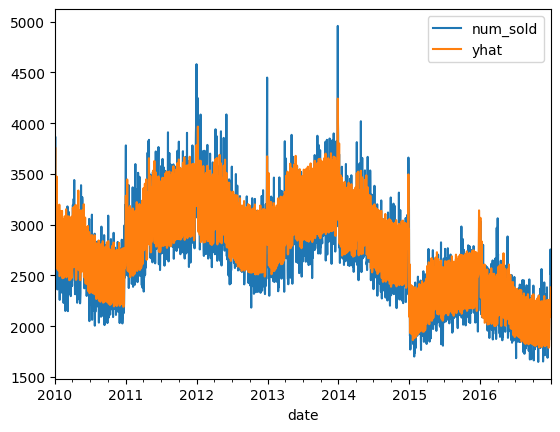

In [38]:
predictions_sample = predictions.query("series_id == 'Norway|Premium Sticker Mart|Kaggle Tiers'")

predictions_sample.set_index('date')[['num_sold', 'yhat']].plot.line()

<Axes: xlabel='date'>

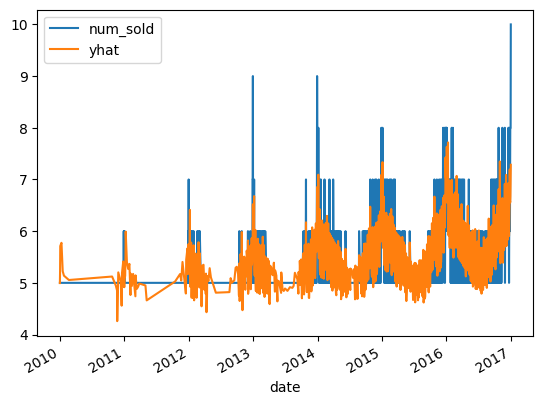

In [39]:
predictions_sample = predictions.query("series_id == 'Kenya|Stickers for Less|Holographic Goose'")

predictions_sample.set_index('date')[['num_sold', 'yhat']].plot.line()

In [40]:
SEGMENTS_MODELS = {
    grp: Ridge(RIDGE_ALPHA_TUNED).fit(XY[FEATURES_LOCAL_MODEL], XY['num_sold_log'])
    for grp, XY in segments_XY.items()
    }

# Deployment

In [41]:
sales_test_daily = pd.read_csv("./data/external/test.csv").assign(
    date = lambda df_: pd.to_datetime(df_['date']),
    series_id = lambda df_: df_['country'].str.cat([df_['store'], df_['product']], sep='|')
    )

In [42]:
sales_test_daily.head()

,id,date,country,store,product,series_id
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose,Canada|Discount Stickers|Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle,Canada|Discount Stickers|Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers,Canada|Discount Stickers|Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler,Canada|Discount Stickers|Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode,Canada|Discount Stickers|Kerneler Dark Mode


In [43]:
sales_test_daily['date'].describe()

count                  98550
mean     2018-07-02 00:00:00
min      2017-01-01 00:00:00
25%      2017-10-01 00:00:00
50%      2018-07-02 00:00:00
75%      2019-04-02 00:00:00
max      2019-12-31 00:00:00
Name: date, dtype: object

In [44]:
sales_test_daily = transform_calendar_features(sales_test_daily)
sales_test_daily = integrate_external_features(sales_test_daily)

In [45]:
sales_test_daily = sales_test_daily.assign(
    num_sold = None,
    num_sold_log = None
)
sales_test_enriched_daily = feature_transform_pipeline.transform(sales_test_daily)

In [46]:
segments_X_test = {grp: df for grp, df in sales_test_enriched_daily.groupby('series_id')}

segments_predictions_test = []
for grp, df in segments_X_test.items():

    if grp in SEGMENTS_MODELS:
        df = df.assign(
            yhat = lambda df_: np.exp(SEGMENTS_MODELS[grp].predict(df_[FEATURES_LOCAL_MODEL])) 
            )  
    else:
        df = df.assign(
            yhat = lambda df_: np.exp(model_global.predict(df_[FEATURES_GLOBAL_MODEL])) 
            )

    segments_predictions_test.append(df)

predictions_test = pd.concat(segments_predictions_test, axis=0)

In [47]:
predictions_test_submit = (
    predictions_test
    [['id', 'yhat']]
    .rename(columns={'yhat': 'num_sold'})
    )

In [48]:
assert predictions_test_submit.shape[0] == 98_550
assert predictions_test_submit.notnull().all().all()
predictions_test_submit.to_csv("./data/processed/submission2.csv", index=False)